## Baseline GCN testing
Notebook to create and evaluate GCN against EBC on predicting number of passing bicyclists in *copenhagen?*
- Preprocess EBC for graph DONE
- Assign Metrics from data
- Create Torch Graph
- Evaluate against SOTA


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/christianrasmussen/Documents/thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/christianrasmussen/Documents/thesis/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/christianrasmussen/Documents/thesis/.venv/lib/python3.12/site-packages/ipykernel/

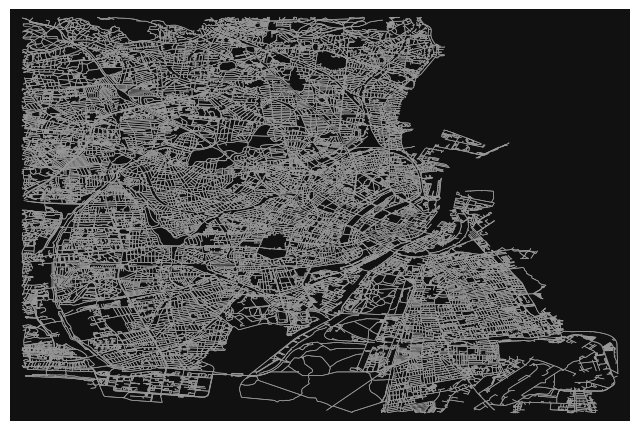

In [2]:
import torch
from torch_geometric.data import Data
import torch_geometric as tg
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap
from shapely.geometry import Point, LineString, Polygon
import shapely
import momepy as mp 
import esda
import seaborn as sns
sns.set_theme()

lat, lon = 55.6867243, 12.5700724

def get_city_graph(lat, lon, dist, polygonize=False, plot = False):
    g = ox.graph_from_point((lat, lon), dist=dist, network_type='bike', simplify=True, retain_all=False)
    gdf = mp.nx_to_gdf(g, points=False, lines=True, spatial_weights=True).to_crs(epsg=3857)
    ### remove rows with geometry == None
    gdf = gdf[gdf.geometry.notnull()]
    gdf = gdf.reset_index(drop=True)
    if polygonize:
        linestrings = gdf[1].geometry # our geopandas.GeoSeries of linestrings representing street network
        collection = shapely.GeometryCollection(linestrings.array)  # combine to a single object
        noded = shapely.node(collection)  # add missing nodes
        polygonized = shapely.polygonize(noded.geoms)  # polygonize based on an array of noded parts
        polygons = gpd.GeoSeries(polygonized.geoms)  # create a GeoSeries from parts
        return g, gdf, polygons
    if plot:
        ### plot the graph
        fig, ax = ox.plot_graph(g, node_size=0, edge_linewidth=0.5, show=False, close=False)
        gdf[1].plot(ax=ax, linewidth=1, edgecolor='black')
        plt.show()
    return g, gdf


g, gdf = get_city_graph(lat, lon, 10000)

### plot the graph
fig, ax = ox.plot_graph(g, node_size=0, edge_linewidth=0.5, show=False, close=False)
gdf.plot(ax=ax, linewidth=1, edgecolor='black')

import nx_parallel as nxp
import networkx as nx

# enabling networkx's config for nx-parallel
nx.config.backends.parallel.active = True

# setting `n_jobs` (by default, `n_jobs=None`)
nx.config.backends.parallel.n_jobs = 4

### carry weights over to line graph
H = nx.line_graph(g)
H.add_nodes_from((node, g.edges[node]) for node in H)   

for s, t, v in H.edges:
    H.edges[(s, t, v)]['weight'] = g.edges[s]['length'] + g.edges[t]['length']


### EBC Calculation

In [ ]:
import tqdm
def calc_bc(shortest_paths, graph):
    bc = {i : 0 for i in graph.nodes}
    for node in tqdm.tqdm(graph.nodes):
        for other_node in shortest_paths[node].keys():
            path = set(shortest_paths[node][other_node])
            for node_visited in path:
                bc[node_visited] += 1
    for node in bc.keys():
        bc[node] /= graph.number_of_nodes()**2
        print(node, bc[node])
    return bc

ebc = dict(nxp.all_pairs_dijkstra_path(H, weight='weight',
                                        cutoff=2500,
                                        ))
bc = calc_bc(ebc, H)
# bc = {k: v for k, v in sorted(bc.items(), key=lambda item: item[1], reverse=True)}


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104c4fb00>>
Traceback (most recent call last):
  File "/Users/christianrasmussen/Documents/thesis/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
### color edges in g by bc
bc2 = {}
for x, y, z in bc:
    bc2[(x, y)] = bc[(x, y, z)]


In [ ]:
for (s, t), value in bc2.items():
    for i in range(len(g[s][t])):
        g[s][t][i]['bc'] = value


### Counter data assignment

# TODO

In [ ]:
nodes, edges = mp.nx_to_gdf(g)

import geopandas as gpd 
import pandas as pd 

filepath = '/Users/christianrasmussen/Documents/thesis/bike-flow-estimate/data/raw/trafiktaelling.json'

gdf = gpd.GeoDataFrame.from_file(filepath)
gdf.set_crs(epsg=4326, inplace=True)
gdf['geometry'] = gdf['geometry']

### export only relevant columns
gdf_new = gdf[['id', 'vejnavn', 'geometry', 'aadt_cykler']]

### remove null values on aadt_cykler
gdf_new = gdf_new[gdf_new['aadt_cykler'].notnull()]


In [ ]:
from shapely.geometry import Point

linestrings = [i[2]['geometry'] if 'geometry' in i[2] else None for i in list(g.edges(data=True))]
from_node = [i[0] for i in list(g.edges(data=True))]
to_node = [i[1] for i in list(g.edges(data=True))]
# g = nx.Graph(g)

def find_nearest_edge(linestrings, point, from_node, to_node):
    # Initialize variables to find the closest edge
    shortest_distance = float('inf')
    closest_edge = None
    node_pair = None
    for linestring, n1, n2 in zip(linestrings, from_node, to_node): 
        if linestring is not None:
            # Calculate the distance between the point and the edge
            distance = linestring.distance(point)
            if distance < shortest_distance:
                shortest_distance = distance
                closest_edge = linestring
                node_pair = (n1, n2)
    return closest_edge, shortest_distance, node_pair


In [ ]:
g2 = g.copy()
import tqdm
for i, row in tqdm.tqdm(gdf_new.iterrows(), total=len(gdf_new)):
    point = row['geometry']
    closest_edge, shortest_distance, node_pair = find_nearest_edge(linestrings, point, from_node, to_node)
    try:
        if not 'aadt' in g2[node_pair[0]][node_pair[1]][0].keys():
            g2[node_pair[0]][node_pair[1]][0]['aadt'] = row['aadt_cykler']
            g2[node_pair[0]][node_pair[1]][0]['aadt_dist'] = shortest_distance
        elif g2[node_pair[0]][node_pair[1]][0]['aadt_dist'] > shortest_distance:
            print('IT HAPPENED!!!')
            g2[node_pair[0]][node_pair[1]][0]['aadt'] = row['aadt_cykler']
            g2[node_pair[0]][node_pair[1]][0]['aadt_dist'] = shortest_distance
    except:
        print(node_pair)
        print(row['aadt_cykler'])
        print(i)


In [ ]:
for s, t, value in g2.edges(data=True):
    if 'aadt' not in value.keys():
        value['aadt'] = 0


In [ ]:
print(np.sum(gdf_new['aadt_cykler'].isna()))
gdf_new['aadt_cykler'].describe()


In [ ]:
from sklearn.linear_model import LinearRegression
x, y = [], []
for s, t, v in list(g2.edges(data=True)):
    if v['aadt'] > 0:
        x.append(v['bc'])
        y.append(v['aadt'])


In [ ]:
model = LinearRegression().fit(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1))
model.score(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1))


In [ ]:
sns.scatterplot(x=x, y=y)


In [ ]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(x, y))
print(spearmanr(x, y))


### Creating Torch Graph from **edgelist**

To be used as we convert graphs with calculated betweenness centralities and run our GCN over them. <br>
**TODO: Functionize**

In [ ]:
edge_list = []
for s, t, v in list(g2.edges(data=True)):
    edge_list.append(((s, t), (v['bc'], v['aadt'])))

# Step 1: Create node mapping (string -> integer)
node_to_idx = {}
for (src, tgt), _ in edge_list:
    if src not in node_to_idx:
        node_to_idx[src] = len(node_to_idx)
    if tgt not in node_to_idx:
        node_to_idx[tgt] = len(node_to_idx)

# Step 2: Extract edge index and features
edge_index = []
edge_attr = []

for (src, tgt), feature in edge_list:
    edge_index.append([node_to_idx[src], node_to_idx[tgt]])
    edge_attr.append(feature)

# Convert to torch tensors
edge_index = torch.tensor(edge_index, dtype=torch.long).t()  # Shape: [2, num_edges]
edge_attr = torch.tensor(edge_attr, dtype=torch.float)  # Shape: [num_edges, feature_dim]

# Create graph object
graph = Data(edge_index=edge_index, edge_attr=edge_attr)

# Print output
print(graph)


In [ ]:
# import pickle 

# with open('../data/graphs/graph_nx.pkl', 'wb') as f:
#     pickle.dump(g, f)


### Creating torch-geometric GCN

In [ ]:
## set column 1 as x feature
graph.x = torch.tensor(edge_attr[:, 0], dtype=torch.float).reshape(-1, 1)

## set column 2 as y feature
graph.y = torch.tensor(edge_attr[:, 1], dtype=torch.float).reshape(-1, 1)


In [ ]:
# import pickle 

# with open('../data/graphs/graph.pkl', 'wb') as f:
#     pickle.dump(graph, f)
